<a href="https://colab.research.google.com/github/ogigo/flask_app/blob/main/flask_dog_vs_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
api_token = {"username":"kajolmaster","key":"dbb23ceaca2a39397c3e92d83fda1034"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:json.dump(api_token, file)

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download samuelcortinhas/cats-and-dogs-image-classification

 98% 63.0M/64.4M [00:02<00:00, 36.9MB/s]
100% 64.4M/64.4M [00:02<00:00, 27.0MB/s]


In [ ]:
!unzip cats-and-dogs-image-classification.zip

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input
from tensorflow.keras.layers import Dense , Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.4)

In [8]:
train_image_dir="/content/train/"
test_image_dir="/content/test"

In [9]:
train_data_generator=ImageDataGenerator( validation_split=0.15,
                                        rotation_range=15,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        preprocessing_function=preprocess_input,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

valid_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.15)
test_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
train_generator=train_data_generator.flow_from_directory(train_image_dir,
                                                         target_size=(256,256),
                                                         batch_size=32,
                                                         shuffle=True,
                                                         seed=42,
                                                         class_mode="categorical",
                                                         subset="training")

valid_generator=valid_data_generator.flow_from_directory(train_image_dir,
                                                         target_size=(256,256),
                                                         batch_size=32,
                                                         shuffle=False,
                                                         seed=42,
                                                         class_mode="categorical",
                                                         subset="validation")

test_generator=test_data_generator.flow_from_directory(test_image_dir,
                                                         target_size=(256,256),
                                                         batch_size=32,
                                                         shuffle=False,
                                                         seed=42,
                                                         class_mode="categorical")

nb_train_samples = train_generator.samples
nb_validation_samples = valid_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 475 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Classes:['cats', 'dogs']


In [11]:
base_model=InceptionResNetV2(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))

x=base_model.output
x=Flatten()(x)
x=Dense(100,activation="relu")(x)
prediction=Dense(num_classes,activation="softmax",kernel_initializer="random_uniform")(x)

219055592/219055592 [==============================] - 7s 0us/step


In [12]:
model=Model(inputs=base_model.input,outputs=prediction)

for layer in base_model.layers:
  layer.trainable=False

In [13]:
model.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
# Save the best model
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)

In [15]:
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // 32,
        epochs=5,
        callbacks=[save_checkpoint,early_stopping],
        validation_data=valid_generator,
        verbose=True,
        validation_steps=nb_validation_samples // 32)

Epoch 1/5
14/14 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.8736
Epoch 1: val_loss improved from inf to 0.08766, saving model to model.h5
14/14 [==============================] - 36s 1s/step - loss: 0.5441 - accuracy: 0.8736 - val_loss: 0.0877 - val_accuracy: 0.9688
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9707
Epoch 2: val_loss improved from 0.08766 to 0.06216, saving model to model.h5
14/14 [==============================] - 15s 1s/step - loss: 0.0877 - accuracy: 0.9707 - val_loss: 0.0622 - val_accuracy: 0.9844
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9865
Epoch 3: val_loss did not improve from 0.06216
14/14 [==============================] - 14s 953ms/step - loss: 0.0344 - accuracy: 0.9865 - val_loss: 0.0975 - val_accuracy: 0.9844
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9910
Epoch 4: val_loss did not improve from 0.

In [16]:
history_dict=history.history
loss_values=history_dict["loss"]
val_loss_values=history_dict["val_loss"]

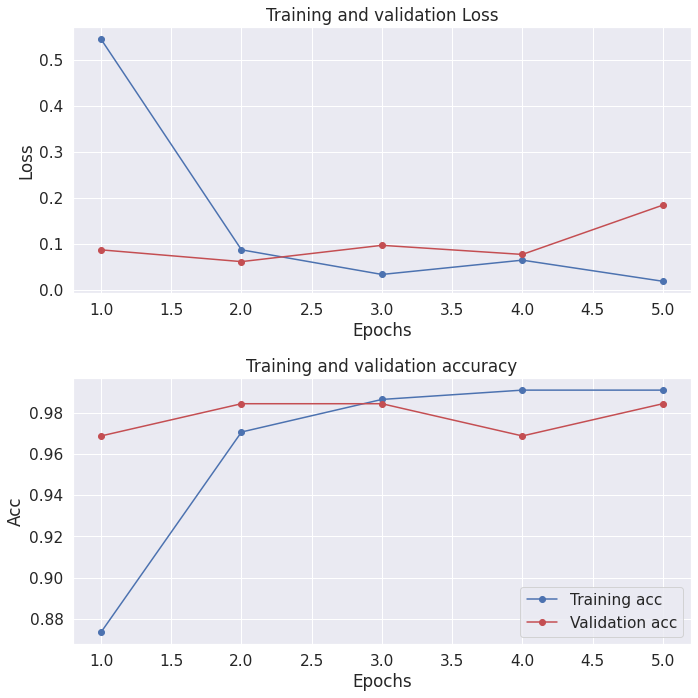

In [17]:
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Evaluate on validation dataset
score = model.evaluate(valid_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.14435678720474243
Val accuracy: 0.9878048896789551


In [19]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19695815443992615
Test accuracy: 0.949999988079071


5/5 [==============================] - 5s 417ms/step


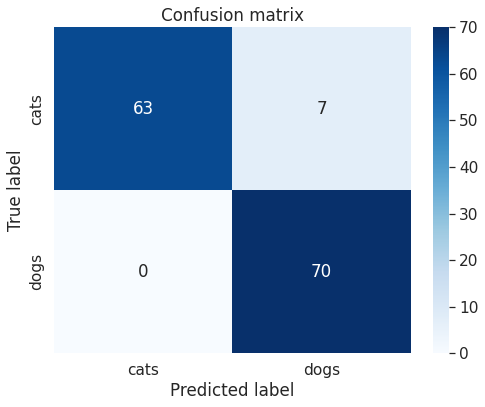

In [20]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [21]:
import cv2
img=cv2.imread("/content/test/dogs/dog_114.jpg")
img=cv2.resize(img,(256,256))
img=np.resize(img,(1,256,256,3))

In [22]:
def image_preprocess(image_file):
  image=cv2.imread(image_file)
  image=cv2.resize(image,(256,256))
  image=np.resize(image,(1,256,256,3))
  return image

In [23]:
pred=model.predict(img)
pred_digit=np.argmax(pred,axis=1)

1/1 [==============================] - 4s 4s/step


In [24]:
pred_digit

array([1])

In [25]:
!pip install flask_ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=af4bf252f266a8de0eb625b77a31881b07701f1024caee4b1508ac360ee089c0
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [27]:
from pyngrok import ngrok

In [28]:
ngrok.set_auth_token("2HWTWDFu58DTBgSJ1pw1pucq7zL_2SRvzVZsrmYkBwrcjh51U")

In [29]:
from flask import Flask
from flask_ngrok import run_with_ngrok

In [30]:
app=Flask(__name__)

In [31]:
@app.route("/")
def home():
  image_id=image_preprocess("/content/test/cats/cat_1.jpg")
  pred=model.predict(image_id)
  pred_digits=np.argmax(pred,axis=1)
  predict=str(pred_digits)
  return predict

In [32]:
run_with_ngrok(app)
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://6a0c-35-204-64-176.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
1/1 [==============================] - 0s 44ms/step


INFO:werkzeug:127.0.0.1 - - [20/Jan/2023 05:17:12] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Jan/2023 05:17:12] "GET /favicon.ico HTTP/1.1" 404 -
